# ACB - Music classification - Scenario A

## Import libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from imblearn.over_sampling import SMOTE

from sklearn import set_config
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    matthews_corrcoef,
    make_scorer,
    RocCurveDisplay,
)


from music_classification.visualization.visualize import (
    pairplot,
    class_distribution,
    interpret_steps,
    plot_pca,
)
from music_classification.utils.dotenv_loading import ENV_CONFIG
from music_classification.data.process_data import clean_dataset, define_pipeline

%matplotlib inline

Show the versions of the modules used for the project:

In [18]:
print(f"{np.__name__} version = {np.__version__}")
print(f"{pd.__name__} version = {pd.__version__}")
print(f"{sklearn.__name__} version = {sklearn.__version__}")
print(f"{mpl.__name__} version = {mpl.__version__}")
print(f"{sns.__name__} version = {sns.__version__}")

numpy version = 1.23.5
pandas version = 2.0.1
sklearn version = 1.2.2
matplotlib version = 3.7.0
seaborn version = 0.12.2


In [19]:
SAVE = True

SEED = int(ENV_CONFIG["SEED"])
np.random.default_rng(seed=SEED)

Generator(PCG64) at 0x7F7EE690CF20

In [20]:
set_config(display="diagram")

## Reading the data and quick exploratory data analysis

In [21]:
df_raw = pd.read_csv(ENV_CONFIG["DATA_FOLDER"], dtype_backend="pyarrow")
df_raw.shape

(999, 199)

In [22]:
df_raw.head()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,rms_mean_max,rms_mean_min,rms_mean_median,rms_mean_qt1,rms_mean_qt2,spectral_centroid_mean_mean,spectral_centroid_mean_var,spectral_centroid_mean_max,spectral_centroid_mean_min,spectral_centroid_mean_median,spectral_centroid_mean_qt1,spectral_centroid_mean_qt2,spectral_bandwidth_mean_mean,spectral_bandwidth_mean_var,spectral_bandwidth_mean_max,spectral_bandwidth_mean_min,spectral_bandwidth_mean_median,spectral_bandwidth_mean_qt1,spectral_bandwidth_mean_qt2,rolloff_mean_mean,rolloff_mean_var,rolloff_mean_max,rolloff_mean_min,rolloff_mean_median,rolloff_mean_qt1,rolloff_mean_qt2,zero_crossing_rate_mean_mean,zero_crossing_rate_mean_var,zero_crossing_rate_mean_max,...,mfcc_mean_14_min,mfcc_mean_14_median,mfcc_mean_14_qt1,mfcc_mean_14_qt2,mfcc_mean_15_mean,mfcc_mean_15_var,mfcc_mean_15_max,mfcc_mean_15_min,mfcc_mean_15_median,mfcc_mean_15_qt1,mfcc_mean_15_qt2,mfcc_mean_16_mean,mfcc_mean_16_var,mfcc_mean_16_max,mfcc_mean_16_min,mfcc_mean_16_median,mfcc_mean_16_qt1,mfcc_mean_16_qt2,mfcc_mean_17_mean,mfcc_mean_17_var,mfcc_mean_17_max,mfcc_mean_17_min,mfcc_mean_17_median,mfcc_mean_17_qt1,mfcc_mean_17_qt2,mfcc_mean_18_mean,mfcc_mean_18_var,mfcc_mean_18_max,mfcc_mean_18_min,mfcc_mean_18_median,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
0,blues.00000.wav,123.046875,0.350129,0.088772,1.0,0.001883,0.254469,0.112016,0.509971,0.130184,0.002828,0.324014,0.019080,0.126017,0.088005,0.164684,1784.122641,129745.484539,4031.364538,1027.079258,1739.018858,1563.128823,1953.080420,2002.412407,85834.410362,3220.590296,1306.709966,2005.771190,1812.074297,2180.473578,3805.723030,9.012529e+05,7644.287109,1830.322266,3649.877930,3111.547852,4338.940430,0.083045,0.000767,0.242676,...,-29.650528,-5.482690,-9.757141,-0.658551,0.751706,52.424534,29.991364,-20.374256,0.843299,-4.445824,5.764967,-1.687854,36.535866,19.031840,-20.197773,-1.974539,-5.904931,2.361849,-0.408730,41.603170,18.939028,-21.336136,-0.813133,-5.025369,3.861850,-2.302677,55.053654,27.253826,-26.759907,-2.695520,-7.189630,1.837867,1.222467,46.941350,32.866340,-23.219631,0.941804,-3.579244,5.497650,blues
1,blues.00001.wav,107.666016,0.340849,0.094976,1.0,0.001808,0.232328,0.089450,0.521089,0.095908,0.002373,0.271687,0.004361,0.093810,0.062110,0.129018,1530.261767,375915.508522,5444.293577,421.091729,1462.001794,1121.481429,1827.115598,2038.987608,213905.102951,3402.554398,1046.389224,2050.470546,1717.987817,2357.010773,3550.713616,2.978311e+06,8085.717773,333.764648,3219.213867,2304.052734,4844.970703,0.056040,0.001448,0.323730,...,-26.848995,-5.885581,-11.640203,-0.975775,0.929294,55.337963,29.639198,-29.272682,0.225810,-4.004313,5.572113,-0.728403,60.231407,24.525185,-23.340874,-0.944975,-5.842802,4.687471,0.296872,48.133213,21.542437,-18.384598,-0.124006,-4.365063,4.840891,-0.282430,51.106014,27.737759,-24.408875,-0.422776,-4.961407,4.222943,0.530644,45.788700,27.740532,-17.131062,0.290101,-4.288013,4.693344,blues
2,blues.00002.wav,161.499023,0.363538,0.085257,1.0,0.003168,0.275098,0.130408,0.520045,0.175473,0.002751,0.326591,0.039753,0.174108,0.134808,0.211978,1552.832481,156471.011012,4669.770713,417.254802,1510.972589,1332.152020,1717.748903,1747.754087,76295.413458,2662.739385,960.211956,1741.173116,1563.982661,1941.645703,3042.410115,7.841309e+05,6556.860352,441.430664,2906.982422,2400.952148,3585.278320,0.076291,0.001007,0.440918,...,-26.859531,-9.592031,-13.295398,-5.516605,2.448304,40.641678,23.645119,-16.723423,2.328213,-1.984192,6.688635,-7.724840,47.629646,15.935514,-29.231827,-7.953848,-12.541105,-3.855764,-1.819024,52.393597,26.848488,-26.768690,-1.804829,-6.421876,2.671648,-3.440458,46.643400,20.980637,-20.417923,-4.505918,-8.082528,0.335357,-2.238128,30.653150,16.524359,-29.785423,-2.112655,-5.789953,

In [23]:
df_raw.tail()

,filename,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,rms_mean_max,rms_mean_min,rms_mean_median,rms_mean_qt1,rms_mean_qt2,spectral_centroid_mean_mean,spectral_centroid_mean_var,spectral_centroid_mean_max,spectral_centroid_mean_min,spectral_centroid_mean_median,spectral_centroid_mean_qt1,spectral_centroid_mean_qt2,spectral_bandwidth_mean_mean,spectral_bandwidth_mean_var,spectral_bandwidth_mean_max,spectral_bandwidth_mean_min,spectral_bandwidth_mean_median,spectral_bandwidth_mean_qt1,spectral_bandwidth_mean_qt2,rolloff_mean_mean,rolloff_mean_var,rolloff_mean_max,rolloff_mean_min,rolloff_mean_median,rolloff_mean_qt1,rolloff_mean_qt2,zero_crossing_rate_mean_mean,zero_crossing_rate_mean_var,zero_crossing_rate_mean_max,...,mfcc_mean_14_min,mfcc_mean_14_median,mfcc_mean_14_qt1,mfcc_mean_14_qt2,mfcc_mean_15_mean,mfcc_mean_15_var,mfcc_mean_15_max,mfcc_mean_15_min,mfcc_mean_15_median,mfcc_mean_15_qt1,mfcc_mean_15_qt2,mfcc_mean_16_mean,mfcc_mean_16_var,mfcc_mean_16_max,mfcc_mean_16_min,mfcc_mean_16_median,mfcc_mean_16_qt1,mfcc_mean_16_qt2,mfcc_mean_17_mean,mfcc_mean_17_var,mfcc_mean_17_max,mfcc_mean_17_min,mfcc_mean_17_median,mfcc_mean_17_qt1,mfcc_mean_17_qt2,mfcc_mean_18_mean,mfcc_mean_18_var,mfcc_mean_18_max,mfcc_mean_18_min,mfcc_mean_18_median,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,label
994,rock.00095.wav,103.359375,0.351977,0.080479,1.0,0.005424,0.263867,0.130719,0.486072,0.079446,0.000346,0.141358,0.038814,0.077952,0.065283,0.092293,2008.174521,282095.547520,4493.780095,928.102055,1907.455191,1637.994883,2260.730506,2106.314092,88556.090699,3115.195030,1407.745591,2075.861638,1900.650928,2273.161347,4253.623647,1.222211e+06,7902.685547,1894.921875,3951.342773,3509.912109,4866.503906,0.089227,0.001305,0.318848,...,-32.900856,-10.138198,-13.899012,-5.913830,1.803152,45.036552,21.133383,-22.390190,2.279496,-2.252842,6.238534,-13.293470,41.667390,8.686502,-36.734230,-13.286467,-17.448229,-9.025370,2.483825,36.720833,28.858143,-20.483223,2.401507,-0.912214,6.488497,-6.716792,54.836437,13.160243,-35.262405,-6.286712,-10.667875,-2.157617,-1.198403,49.946903,21.106043,-22.082030,-0.870149,-5.877096,3.354293,rock
995,rock.00096.wav,117.453835,0.398869,0.075117,1.0,0.015388,0.323889,0.184963,0.541574,0.076423,0.000589,0.145047,0.023601,0.079569,0.056317,0.093838,2006.827265,182135.837356,3688.282904,839.324247,1961.948339,1759.316571,2255.314167,2068.839259,82342.177456,2942.424458,1329.067135,2062.232449,1863.375120,2264.639134,4149.171791,1.046246e+06,7396.655273,1550.390625,3994.409180,3499.145508,4780.371094,0.097664,0.000868,0.195312,...,-25.511253,-4.782448,-8.717762,0.022944,3.736333,33.842625,21.045520,-19.032288,4.104831,0.165199,7.690936,-10.860102,39.252410,8.049336,-29.609457,-11.019108,-15.355202,-7.263675,1.877821,32.027824,23.387863,-13.217052,1.805669,-1.943703,5.586296,-7.468264,39.176170,13.338040,-26.807460,-7.144960,-11.642376,-3.169349,-2.791855,31.719294,14.861097,-19.902115,-3.008246,-6.528909,0.997393,rock
996,rock.00097.wav,129.199219,0.431980,0.075221,1.0,0.006835,0.370889,0.216633,0.591718,0.081598,0.000322,0.132974,0.037343,0.081214,0.067147,0.095287,2077.565822,231716.290821,4301.550281,875.713916,2041.147453,1803.116065,2252.182009,1927.228013,74753.373654,2861.159245,1276.483840,1879.437792,1729.524694,2078.748369,4031.530224,8.044889e+05,7515.087891,2077.954102,3865.209961,3499.145508,4306.640625,0.121823,0.001697,0.314453,...,-31.402880,-11.464001,-15.507771,-7.715511,1.838067,33.591026,20.234394,-17.700493,1.640836,-2.235736,5.485308,-12.851803,36.294918,7.802772,-30.176670,-12.804308,-16.830650,-9.115381,3.445699,35.954890,22.953620,-17.952023,3.347012,-0.234289,7.118936,-12.589926,42.507107,9.248170,-29.989246,-12.964292,-17.128510,-8.109871,-2.104325,29.860994,16.930466,-21.867311,-1.86

In [24]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 199 entries, filename to label
dtypes: double[pyarrow](197), string[pyarrow](2)
memory usage: 1.5 MB


In [25]:
df_raw.iloc[:, -1].unique()

<ArrowExtensionArray>
[    'blues', 'classical',   'country',     'disco',    'hiphop',      'jazz',
     'metal',       'pop',    'reggae',      'rock']
Length: 10, dtype: string[pyarrow]

In [26]:
df = clean_dataset(df_raw, "A", "classical")

In [27]:
df.head()

,tempo,chroma_stft_mean,chroma_stft_var,chroma_stft_max,chroma_stft_min,chroma_stft_median,chroma_stft_qt1,chroma_stft_qt2,rms_mean_mean,rms_mean_var,rms_mean_max,rms_mean_min,rms_mean_median,rms_mean_qt1,rms_mean_qt2,spectral_centroid_mean_mean,spectral_centroid_mean_var,spectral_centroid_mean_max,spectral_centroid_mean_min,spectral_centroid_mean_median,spectral_centroid_mean_qt1,spectral_centroid_mean_qt2,spectral_bandwidth_mean_mean,spectral_bandwidth_mean_var,spectral_bandwidth_mean_max,spectral_bandwidth_mean_min,spectral_bandwidth_mean_median,spectral_bandwidth_mean_qt1,spectral_bandwidth_mean_qt2,rolloff_mean_mean,rolloff_mean_var,rolloff_mean_max,rolloff_mean_min,rolloff_mean_median,rolloff_mean_qt1,rolloff_mean_qt2,zero_crossing_rate_mean_mean,zero_crossing_rate_mean_var,zero_crossing_rate_mean_max,zero_crossing_rate_mean_min,...,mfcc_mean_14_min,mfcc_mean_14_median,mfcc_mean_14_qt1,mfcc_mean_14_qt2,mfcc_mean_15_mean,mfcc_mean_15_var,mfcc_mean_15_max,mfcc_mean_15_min,mfcc_mean_15_median,mfcc_mean_15_qt1,mfcc_mean_15_qt2,mfcc_mean_16_mean,mfcc_mean_16_var,mfcc_mean_16_max,mfcc_mean_16_min,mfcc_mean_16_median,mfcc_mean_16_qt1,mfcc_mean_16_qt2,mfcc_mean_17_mean,mfcc_mean_17_var,mfcc_mean_17_max,mfcc_mean_17_min,mfcc_mean_17_median,mfcc_mean_17_qt1,mfcc_mean_17_qt2,mfcc_mean_18_mean,mfcc_mean_18_var,mfcc_mean_18_max,mfcc_mean_18_min,mfcc_mean_18_median,mfcc_mean_18_qt1,mfcc_mean_18_qt2,mfcc_mean_19_mean,mfcc_mean_19_var,mfcc_mean_19_max,mfcc_mean_19_min,mfcc_mean_19_median,mfcc_mean_19_qt1,mfcc_mean_19_qt2,genre
0,112.347145,0.303251,0.089593,1.0,0.001021,0.192122,0.072654,0.431641,0.026787,0.000342,0.109245,0.002348,0.020586,0.014260,0.034899,822.613953,68125.093750,1968.199463,300.179230,795.296631,638.049988,974.399414,1136.385864,66971.343750,2052.505371,529.798584,1097.548462,938.379272,1295.653687,1434.531006,3.872826e+05,4069.775391,301.464844,1335.058594,979.760742,1765.722656,0.039443,0.000281,0.113770,0.011230,...,-28.255432,-6.639114,-10.558517,-2.132643,-2.432575,37.656082,17.729595,-21.961678,-2.526797,-6.547093,1.322195,-2.676169,41.227890,17.002535,-23.273073,-2.309297,-6.462253,1.451652,-2.284444,45.277039,24.000637,-27.294888,-2.163794,-6.051854,1.946448,-1.159599,69.753036,25.018391,-23.751648,-2.256468,-7.092338,4.157803,-3.818604,88.638634,37.769127,-29.682255,-5.023259,-9.993509,1.511925,classical
1,161.499023,0.376988,0.083790,1.0,0.003654,0.283156,0.150821,0.535613,0.204271,0.001920,0.354226,0.083610,0.202227,0.173548,0.231716,2174.160400,570461.937500,5475.929199,978.054260,2022.619141,1735.808105,2391.136963,2281.058838,206871.000000,3766.266357,1518.510986,2159.732910,1941.545776,2544.266113,4348.073730,2.578227e+06,9410.009766,1948.754883,3703.710938,3402.246094,4936.486816,0.102564,0.002367,0.454590,0.019531,...,-18.398703,0.976450,-3.436091,6.335360,4.423685,61.059113,29.134899,-18.967564,3.978711,-0.738551,9.493345,-6.520481,63.730507,24.949247,-30.702066,-6.471810,-11.909492,-1.016640,-0.034599,47.372089,22.950180,-22.151258,-0.342384,-4.581432,4.140745,-1.411579,41.114128,22.010695,-19.612169,-1.259939,-5.752795,2.507965,-3.078908,51.755867,16.769207,-24.104900,-3.161209,-7.775723,1.794894,others
2,135.999176,0.401009,0.089657,1.0,0.002326,0.331715,0.145864,0.598354,0.182285,0.003976,0.359245,0.039848,0.173792,0.133371,0.233562,1945.252563,147430.671875,3808.051758,1006.970276,1939.487549,1665.321289,2213.842041,2081.762939,73538.992188,2972.428955,1353.437134,2108.613525,1891.240112,2269.803223,4174.460449,8.083841e+05,7611.987305,2067.187500,4166.674805,3531.445312,4844.970703,0.085791,0.001219,0.220215,0.021973,...,-23.650921,-6.812072,-10.991661,-2.245112,3.006186,33.814701,20.619530,-19.578186,2.977468,-0.822829,6.896291,-8.714562,38.764832,11.532606,-38.217838,-8.575090,-12.805531,-4.611633,-0.331766,56.964352,19.503311,-25.116575,-0.164097,-5.295113,4.988887,-2.987200,42.399002,19.443115,-28.507935,-2.744072,-7.306152,1.171250,0.705028,55.644600,23.745577,-22.897854,0.639649,-4.49362

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 198 entries, tempo to genre
dtypes: category(1), float32(197)
memory usage: 770.0 KB


In [29]:
print(f"Number of missing values in the dataset is {df.isnull().sum().sum()}")

Number of missing values in the dataset is 0


Since the number of missing values is zero, there's no need to check each column to see how they're distributed

## Quick plot to check to see each variable distribuition and the correlation between each other

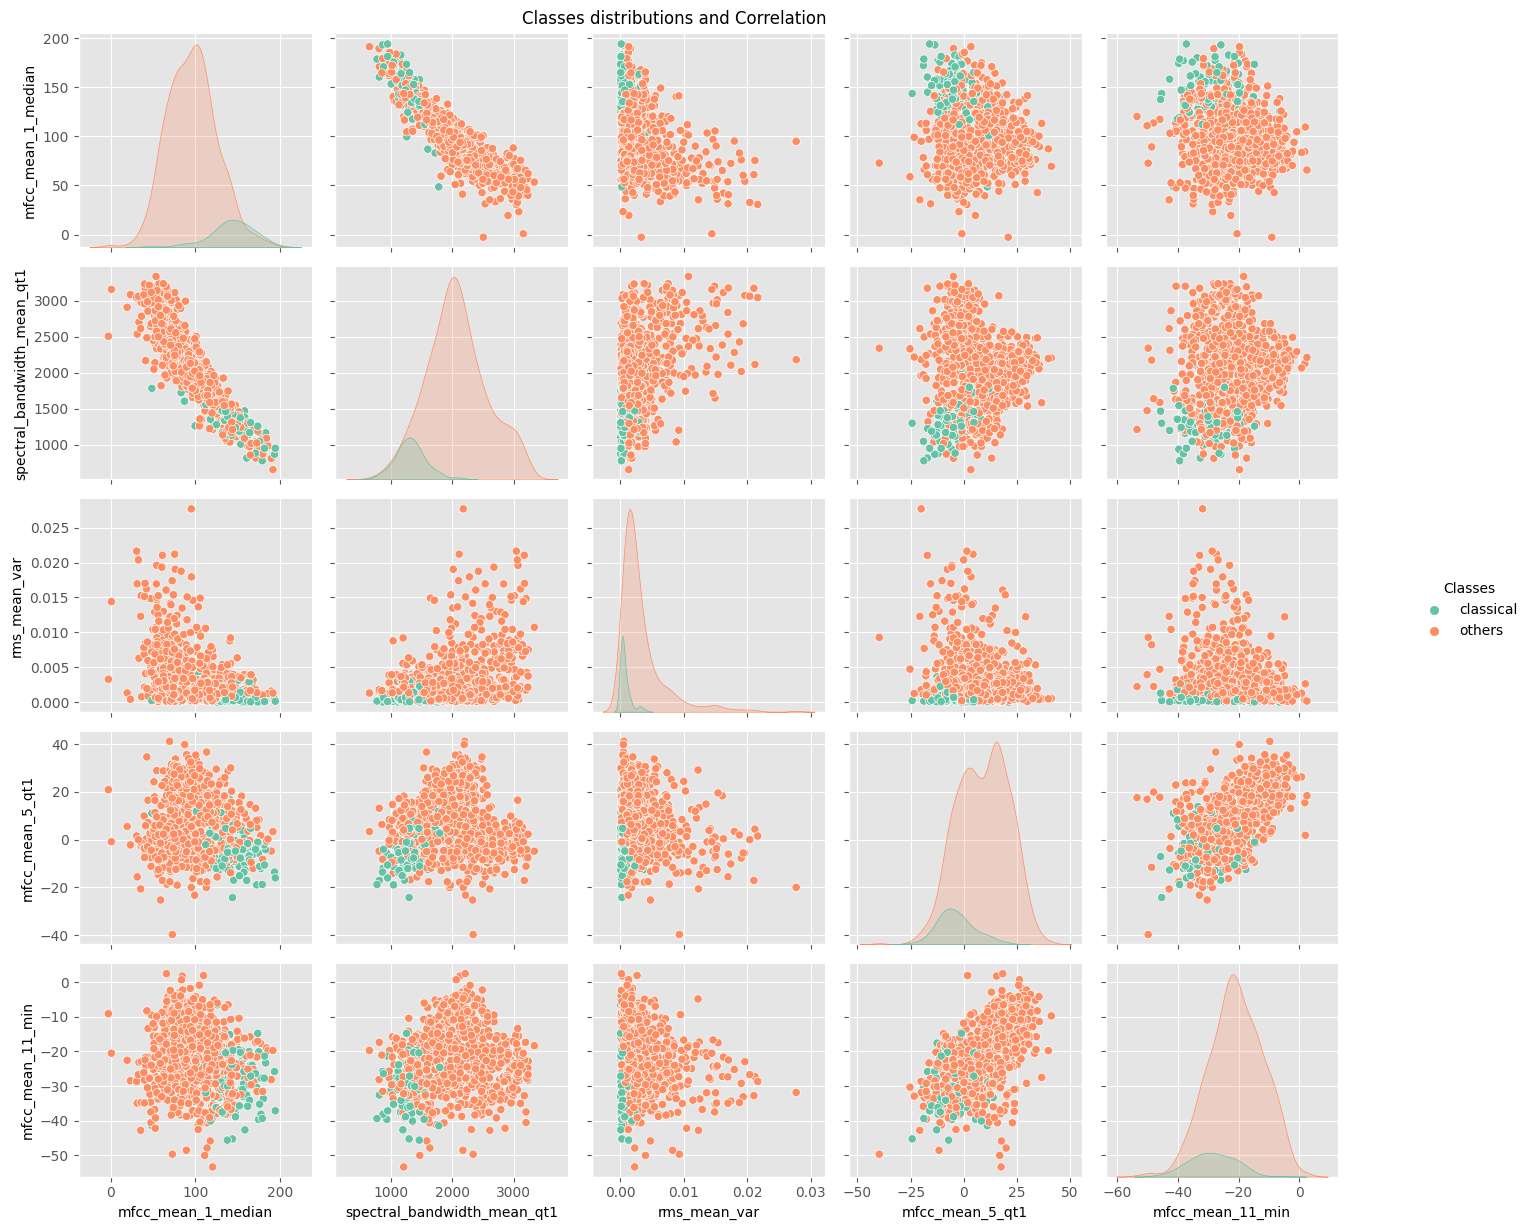

In [30]:
pairplot(data=df, target_variable="genre", save_image=SAVE)

## See the distribution of the target variable, the music genre

For scenario A:
one against all so well pick a genre a treat it like the target variable of interest and the rest as other

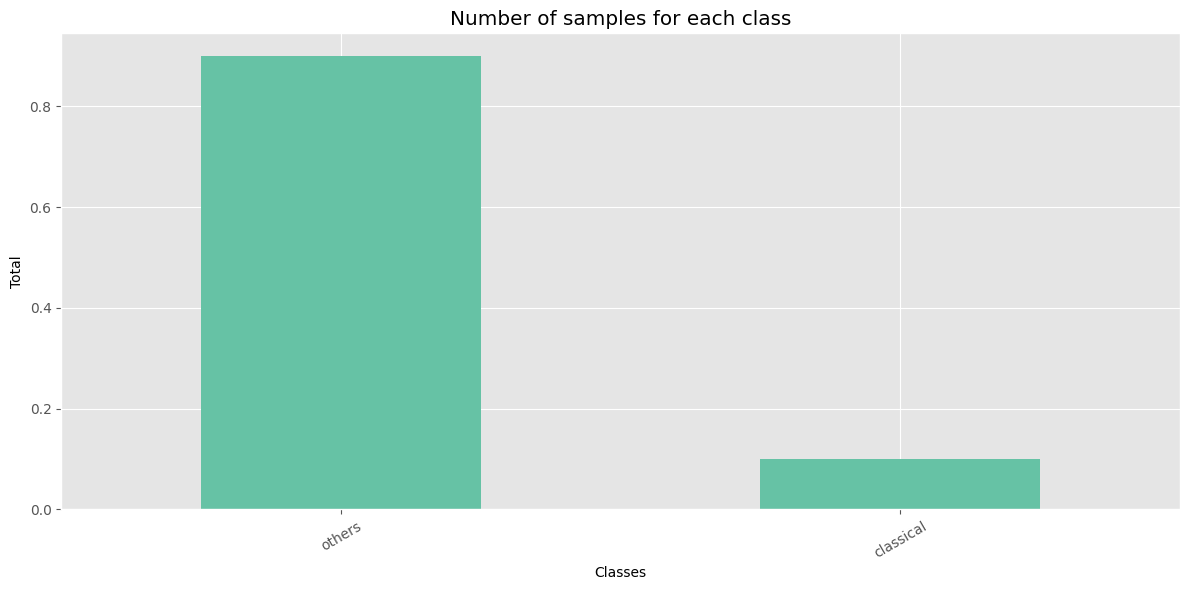

In [31]:
class_distribution(df, target_variable="genre", save_image=SAVE)

With our data cleaned up and with some quick vizualization of our variables we can proceed to the next step.

## Feature selection/Feature reduction

Here we split the dataframe into our features and the target variables.
We also extract the features names with the goal to be able the interpret the feature selection algorithms results.

In [32]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

input_features = df.columns[:-1]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, test_size=0.2
)

In [34]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [35]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([ 75, 724]))

### Removing Outliers from our data

Since models can be negatively affected by the presence of outliers by introducing a certain bias to the models predictions, we think it's important to remove them.
This is only done to the training data to prevent data leak to the test data.

There's a lot of methods to remove outliers from the dataset but since we have a relatively high number of features we chose one already available from the `scikit-learn` module the `Local Outlier Factor`

In [36]:
lof = LocalOutlierFactor()
yhet = lof.fit_predict(X_train)
mask = yhet != -1

In [37]:
X_train, y_train = X_train[mask, :], y_train[mask]

In [38]:
labels, counts = np.unique(y_train, return_counts=True)
le.inverse_transform(labels), counts

(array(['classical', 'others'], dtype=object), array([ 69, 700]))

When we built for the scenario A, we saw in the bar plot that exists a significant class imbalance:
pq que class imbalance é mau.
como resolver o class imbalance
to solve that we need apply some kind of class balancing algorithm

In [39]:
smote = SMOTE()

In [40]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [41]:
pd.DataFrame(y_train).value_counts()

0    700
1    700
Name: count, dtype: int64

### Setting up a pipeline to perform the feature selection / reduction

We think that for this step it is preferable to proceed this way for $2$ reasons:
- It's easy to perform the same processing methods used on the training data to the untouched test data.
- It's also easy to add a model to the last step of the pipeline to have a quick and easy way to perform *p.e.* cross validation.

In our pipeline we defined the following steps:
-  Scaled the data with Standard scaling method.
- Checked for low variance features with a threshold of $\frac{1}{4}$.
- Selected the best $20$ features according to the p-values of an ANOVA statistical test (arbitrary number).

In [42]:
pipeline = define_pipeline()

pipeline()

Pipeline(steps=[('scaler', StandardScaler()),
                ('variance_threshold', VarianceThreshold(threshold=0.25)),
                ('k_best',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x7f7ef4470ca0>)),
                ('pca', PCA(n_components=0.95))])

In [43]:
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [44]:
X_train.shape

(1400, 6)

### Interpret the feature selection / reduction performed

Here we can check which features remained from the pipeline steps

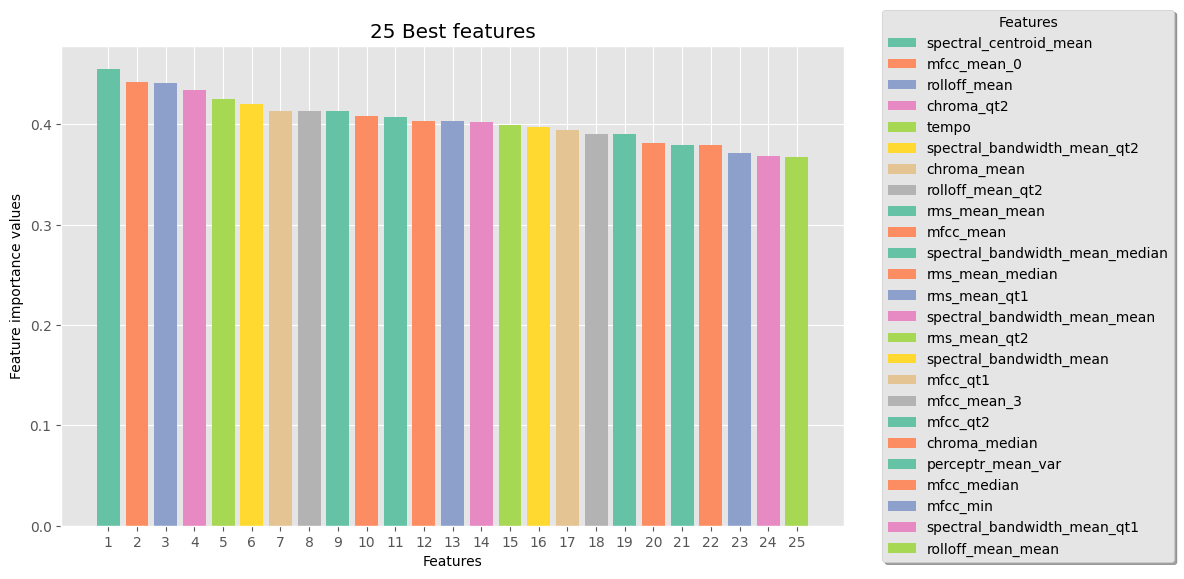

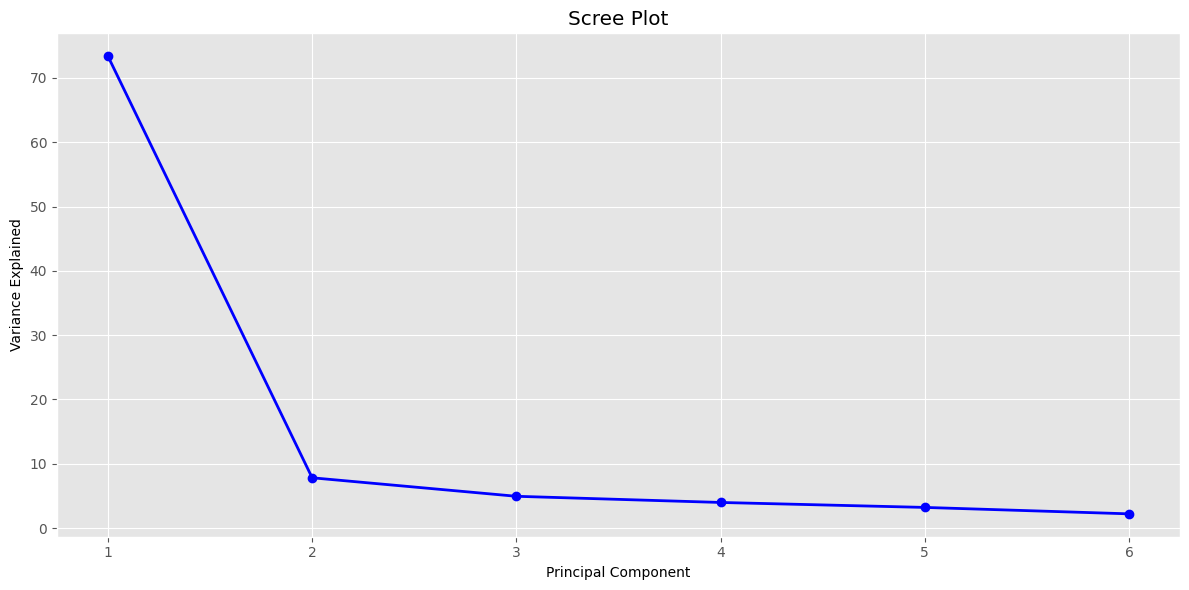

In [45]:
interpret_steps(pipeline=pipeline, features=input_features)

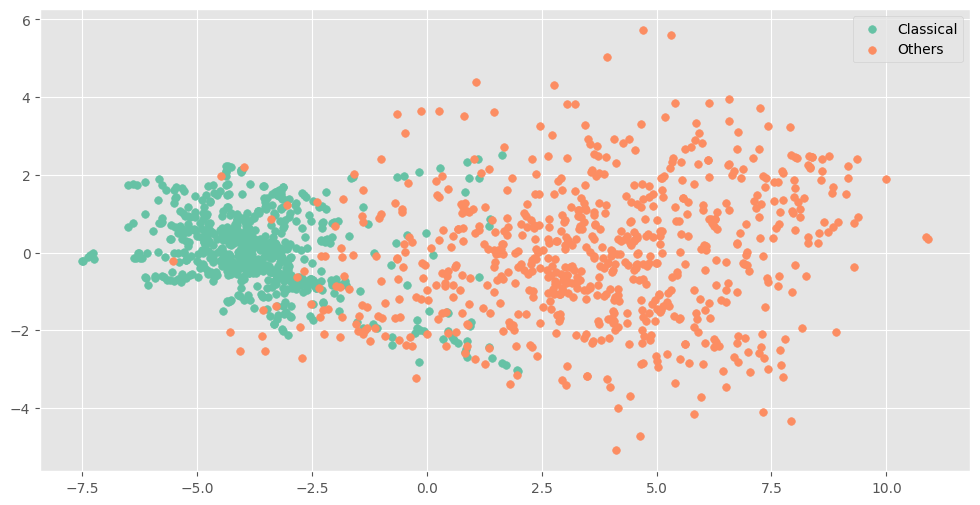

In [46]:
plot_pca(X_train, y_train, le)

In [47]:
def plot_pca(X, y, le):
    ax = plt.subplot()
    for i in range(2):
        ax.scatter(
            X.iloc[y == i, 0],
            X.iloc[y == i, 1],
            c=f"C{i}",
            label=le.inverse_transform([i]).item().capitalize(),
            s=30,
        )

    plt.legend(loc="best")

    plt.show()

In [48]:
X_train, X_grid, y_train, y_grid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED
)

In [49]:
lg_grid = GridSearchCV(
    LogisticRegression(),
    param_grid={"C": [100, 10, 1.0, 0.1, 0.01]},
    scoring="f1",
    n_jobs=4,
    cv=5,
)

lg_grid.fit(X_grid, y_grid)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]}, scoring='f1')

In [50]:
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid={"n_neighbors": np.arange(5, 105, 5)},
    scoring="f1",
    n_jobs=4,
    cv=5,
)

knn_grid.fit(X_grid, y_grid)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])},
             scoring='f1')

In [51]:
rf_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid={"n_estimators": np.arange(10, 101, 5)},
    scoring="f1",
    n_jobs=4,
    cv=5,
)

rf_grid.fit(X_grid, y_grid)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100])},
             scoring='f1')

In [52]:
svm_grid = GridSearchCV(
    SVC(), param_grid={"C": np.arange(1, 50, 5)}, scoring="f1", n_jobs=4, cv=5
)

svm_grid.fit(X_grid, y_grid)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=4,
             param_grid={'C': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])},
             scoring='f1')

In [53]:
models = [
    "LogReg",
    "KNN",
    "LDA",
    "RF",
    "NB",
    "SVM",
]


scores = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "mcc": make_scorer(matthews_corrcoef),
}

In [54]:
lg_crossval_scores = cross_validate(
    LogisticRegression(**lg_grid.best_params_),
    X_train,
    y_train,
    cv=50,
    scoring=scores,
    n_jobs=8,
)

knn_crossval_scores = cross_validate(
    KNeighborsClassifier(**knn_grid.best_params_),
    X_train,
    y_train,
    cv=50,
    scoring=scores,
    n_jobs=8,
)

lda_crossval_scores = cross_validate(
    LDA(), X_train, y_train, cv=50, scoring=scores, n_jobs=8,
)

rf_crossval_scores = cross_validate(
    RandomForestClassifier(**rf_grid.best_params_),
    X_train,
    y_train,
    cv=50,
    scoring=scores,
    n_jobs=8,
)

svm_crossval_scores = cross_validate(
    SVC(**svm_grid.best_params_), X_train, y_train, cv=50, scoring=scores, n_jobs=8
)

nb_crossval_scores = cross_validate(
    GaussianNB(), X_train, y_train, cv=50, scoring=scores, n_jobs=8
)

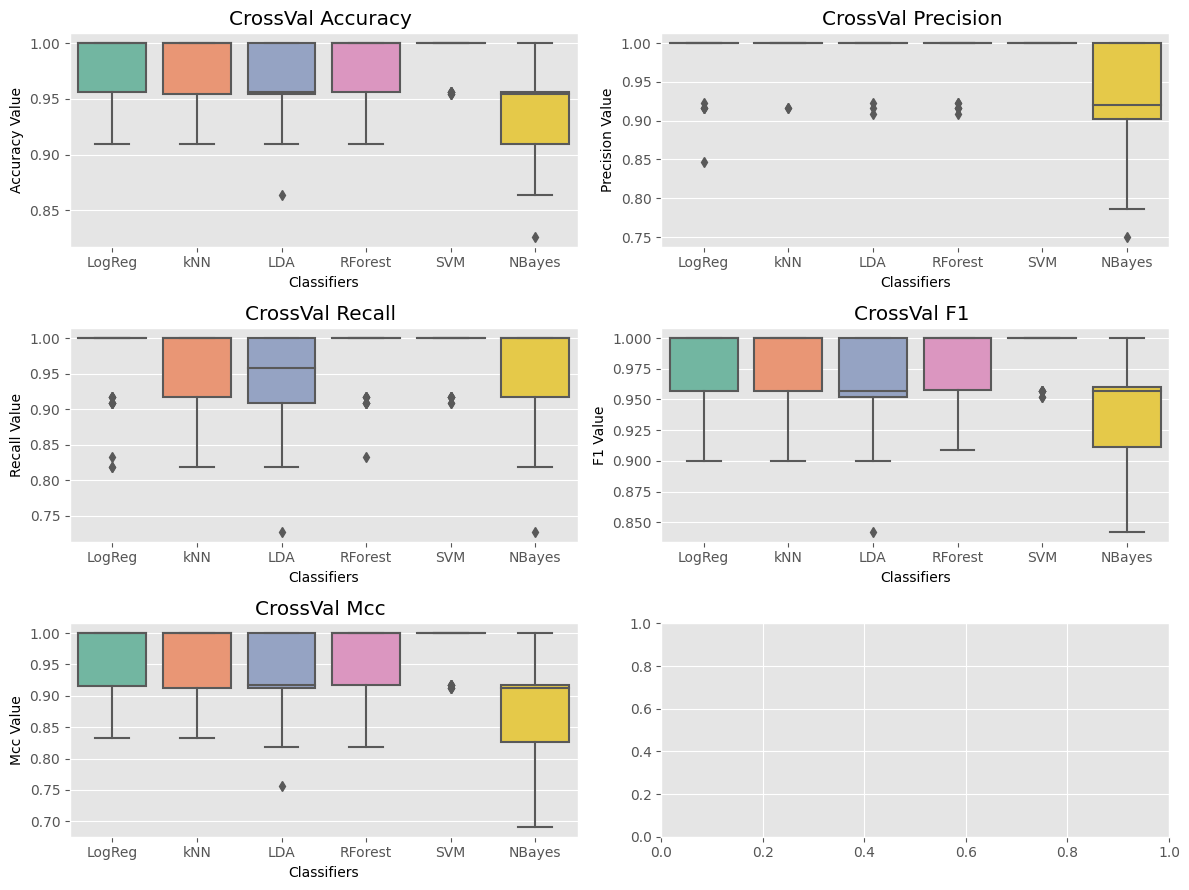

In [55]:
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()

for ax, score in zip(axs, scores.keys()):
    test_score = "test_" + score

    cross_dict = {
        "LogReg": lg_crossval_scores[test_score],
        "kNN": knn_crossval_scores[test_score],
        "LDA": lda_crossval_scores[test_score],
        "RForest": rf_crossval_scores[test_score],
        "SVM": svm_crossval_scores[test_score],
        "NBayes": nb_crossval_scores[test_score],
    }

    cross_val_scores = pd.DataFrame(cross_dict)

    sns.boxplot(cross_val_scores, ax=ax)

    ax.set(
        title=f"CrossVal {score.capitalize()} ",
        xlabel="Classifiers",
        ylabel=f"{score.capitalize()} Value",
    )
plt.tight_layout()

plt.show()

In [56]:
model_instances = [
    LogisticRegression(**lg_grid.best_params_),
    KNeighborsClassifier(**knn_grid.best_params_),
    LDA(),
    RandomForestClassifier(**rf_grid.best_params_),
    SVC(**svm_grid.best_params_),
    GaussianNB(),
]

In [57]:
fitted_models = map(lambda x: x.fit(X_train, y_train), model_instances)
predictions = [*map(lambda x: x.predict(X_test), fitted_models)]

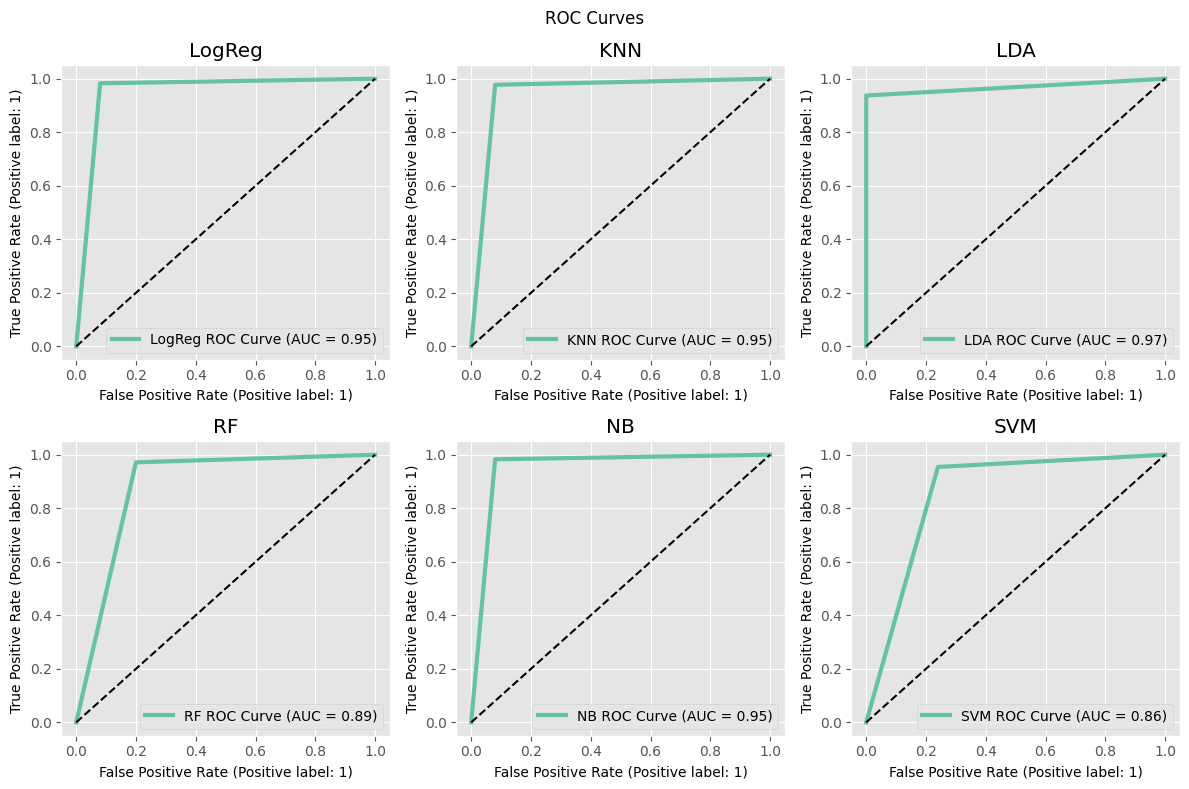

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for model, prediction, ax in zip(models, predictions, axs):
    viz = RocCurveDisplay.from_predictions(
        y_pred=prediction,
        y_true=y_test,
        name=f"{model} ROC Curve",
        lw=3,
        ax=ax,
    )

    ax.set_title(model)

    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

fig.suptitle("ROC Curves")
plt.tight_layout()
plt.show()

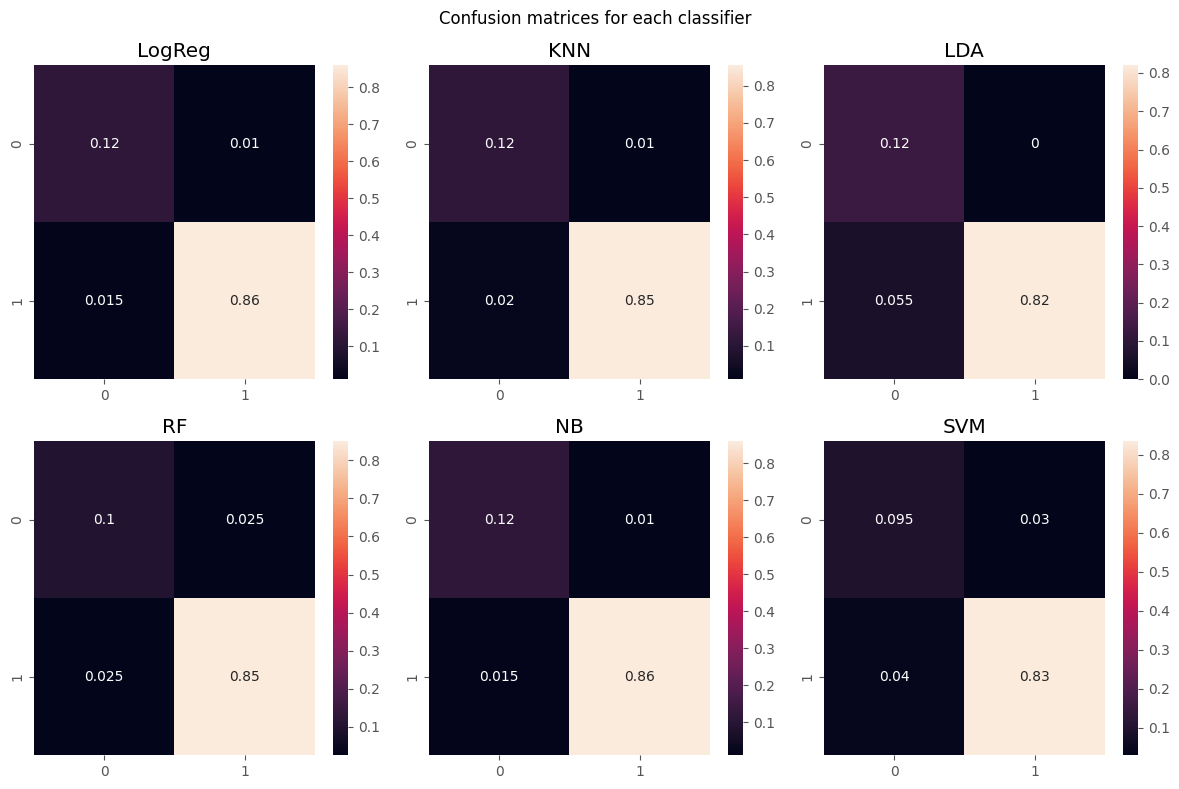

In [59]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for model, predicition, ax in zip(models, predictions, axs):
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=predicition, normalize="all")
    sns.heatmap(conf_matrix, annot=True, ax=ax)
    ax.set_title(model)


fig.suptitle("Confusion matrices for each classifier")

plt.tight_layout()
plt.show()

In [60]:
single_test = pd.DataFrame()
single_test.index = scores.keys()

for model, pred in zip(models, predictions):
    pred_score = {
        "accuracy": accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred),
        "recall": recall_score(y_test, pred),
        "f1": f1_score(y_test, pred),
        "mcc": matthews_corrcoef(y_test, pred),
    }

    single_test[model] = pred_score.values()

single_test.index = single_test.index.str.capitalize()

In [61]:
single_test.round(decimals=3)

,LogReg,KNN,LDA,RF,NB,SVM
Accuracy,0.975,0.970,0.945,0.950,0.975,0.930
Precision,0.989,0.988,1.000,0.971,0.989,0.965
Recall,0.983,0.977,0.937,0.971,0.983,0.954
F1,0.986,0.983,0.968,0.971,0.986,0.960
Mcc,0.888,0.868,0.807,0.771,0.888,0.691
